In [2]:
import gc
from pathlib import Path
from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

DATADIR = Path('./input')

tr_path = DATADIR / 'train.tsv'
test_path = DATADIR / 'test.tsv'
test2_path = DATADIR / 'test2.tsv'

In [47]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [48]:
max(train.item_description.apply(lambda x: len(str(x).split(' '))))

245

In [45]:
train.item_description.value_counts()

No description yet                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     82489
New                                                                                                                                                                                                                                                        

In [ ]:
https://www.kaggle.com/anttip/wordbatch-ftrl-fm-lgb-lbl-0-42555

In [35]:
len(train.name.value_counts())

1225273

In [4]:
train = pd.read_csv(tr_path, sep='\t')
test = pd.read_csv(test_path, sep='\t', parse_dates=True, keep_date_col=True)
train.head()

## Target Variable: Price


左側にSkewしている。log取るとわかりやすい。

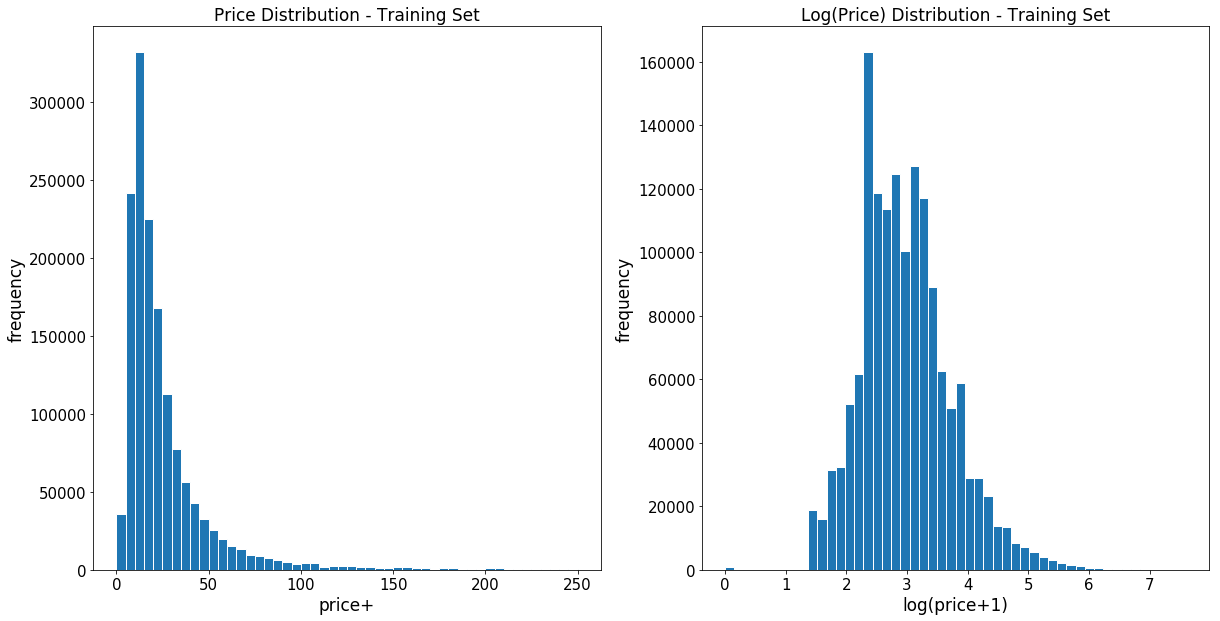

In [28]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

# Shipping

In [29]:
train.shipping.value_counts()/len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

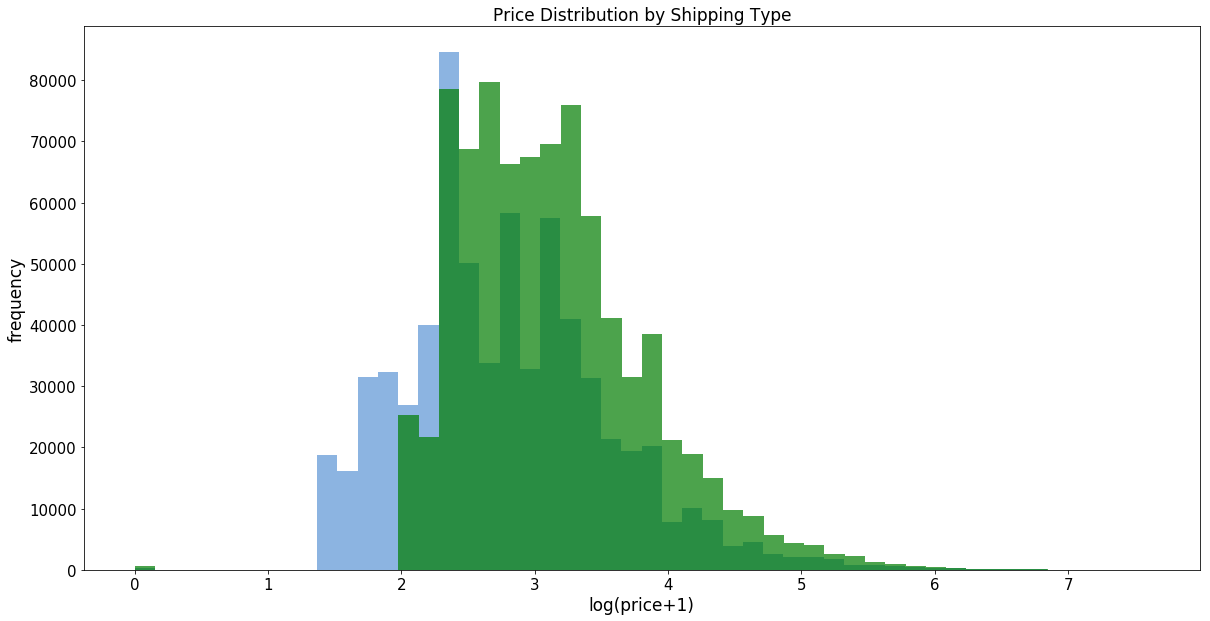

In [30]:
prc_shipBySeller = train.loc[train.shipping==1, 'price']
prc_shipByBuyer = train.loc[train.shipping==0, 'price']

fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipBySeller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()

# Item Category

In [9]:
print("There are %d unique values in the category column." % train['category_name'].nunique())

There are 1287 unique values in the category column.


In [10]:
### TOP 5 RAW CATEGORIES
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

`zip(*xxx)`の下りは、行方向に3つの要素を持つものを、列方向に一つの要素×３

In [13]:
# missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())

# reference: BuryBuryZymon at https://www.kaggle.com/maheshdadhich/i-will-sell-everything-for-free-0-55
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")
    
train['general_cat'], train['subcat_1'], train['subcat_2'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
test['general_cat'], test['subcat_1'], test['subcat_2'] = zip(*test['category_name'].apply(lambda x: split_cat(x)))


print("There are %d unique 1st sub-categories." % train['subcat_1'].nunique())
print("There are %d unique 2nd sub-categories." % train['subcat_2'].nunique())
train.head()

There are 6327 items that do not have a label.
There are 114 unique 1st sub-categories.
There are 871 unique 2nd sub-categories.


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [16]:
test

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality
5,5,iPhone 6 Plus or 6s Plus Vodka pink case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,1,One Absolut Vodka in Pink for iPhone 6 Plus an...,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins"
6,6,Vintage Cameo Pendant & Brooch Pin,3,Women/Jewelry/Necklaces,Vintage,1,Two vintage Cameo pieces. 1. Silver metal Lock...,Women,Jewelry,Necklaces
7,7,Rose Gold Stainless Steel Quartz Watch,1,Women/Women's Accessories/Watches,NaN,1,Brand new Price firm No trades Box included wi...,Women,Women's Accessories,Watches
8,8,Daisy Marc Jacobs 3.4oz,3,Beauty/Fragrance/Women,MARC JACOBS,0,Brand new No box 100% authentic Firm price NO ...,Beauty,Fragrance,Women
9,9,Rose Brushes and Silicone Sponge,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,1,All new. 12 pcs makeup brushes and one Silicon...,Beauty,Tools & Accessories,Makeup Brushes & Tools


In [14]:
x = train['general_cat'].value_counts().index.values.astype('str')
y = train['general_cat'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))]

In [15]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Number of Items by Main Category',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [39]:
x = train['subcat_1'].value_counts().index.values.astype('str')[:15]
y = train['subcat_1'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]

In [40]:
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Number of Items by Sub Category (Top 15)',
              yaxis = dict(title='Count'),
              xaxis = dict(title='SubCategory'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [41]:
general_cats = train['general_cat'].unique()
x = [train.loc[train['general_cat']==cat, 'price'] for cat in general_cats]

In [42]:
layout = dict(title="Price Distribution by General Category",
              yaxis = dict(title='Frequency'),
              xaxis = dict(title='Category'))
fig = dict(data=data, layout=layout)
py.iplot(fig)

NameError: name 'data' is not defined

In [ ]:
# Brand Name 

In [ ]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

In [ ]:
x = train['brand_name'].value_counts().index.values.astype('str')[:10]
y = train['brand_name'].value_counts().values[:10]